<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/tutorials/ENCODE_Jamboree_July2019_DragonnTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to train your DragoNN: 
## Exploring convolutional neural network (CNN) architectures for simulated genomic data as well as ENCODE TF ChIP-seq datasets. 

This tutorial will take approximately 2 hours if executed on a GPU. 

## Outline<a name='outline'>
<ol>
    <li><a href=#1>How to use this tutorial</a></li>
    <li><a href=#2>Review of patterns in transcription factor binding sites</a></li>
    <li><a href=#3>Learning to localize homotypic motif density</a></li>
    <li><a href=#4>Simulate training data with simdna</a></li>  
    <li><a href=#4.5>Running dragonn on your own data: starting with FASTA files</a></li>
    <li><a href=#5>Defining CNN architecture</a></li>
    <li><a href=#6>Single layer, multiple filter model</a></li>
    <li><a href=#7>Model Interpretation</a></li>    
    <li><a href=#8>Regularized multi-layer model</a></li>
    <li><a href=#9>Training on real data: SPI1 ChIP-seq and experimental bQTL data</a></li>
    <li><a href=#10>Genomewide classification and regression labels for SPI1 TF ChIP-seq</a></li>
    <li><a href=#11>Genome-wide classification for SPI1</a></li>
    <li><a href=#12>Genome-wide regression for SPI1</a></li> 
    <li><a href=#13>Genome-wide interpretation of true positive predictions in SPI1</a></li>
    <li><a href=#14>Applications for SPI1 bQTL dataset</a></li>
    <ol>
        <li><a href=#a>Read in and annotate SPI1 bQTL dataset</a></li>
        <li><a href=#b>Obatin DNN predictions for POST and ALT alleles within the bQTL dataset</a></li>
        <li><a href=#c>Compare model predictions on POST and ALT alleles </a></li>
        <li><a href=#d>bQTL dataset motif scan with HOCOMOCO SPI1 motif </a></li>
        <li><a href=#e>bQTL interpretation summary: deep learning models vs motif scan</a></li>
    </ol>
    <li><a href=#15>Deep learning models are able to identify low-affinity TF-binding sites missed by motif scanning.</a></li>
</ol>
    
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.

Github issues on the dragonn repository with feedback, questions, and discussion are always welcome.

 

## How to use this tutorial<a name='1'>
<a href=#outline>Home</a>

This tutorial utilizes a Google Colaboratory Notebook - an interactive computational enviroment that combines live code, visualizations, and explanatory text. The notebook is organized into a series of cells. 

The first thing we do is set our Runtime to use Python3 and GPU. 

![ChangeRuntime](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/ChangeRuntime.png?raw=true)

![RuntimeType.png](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/RuntimeType.png?raw=1)

Now that we set our Runtime, we can execute the cells in the notebook. You can execute the cells one at a time by clicking inside of them and pressing SHIFT+enter. Alternatively, you can run all the cells by clicking the "Run All" button, as demonstrated below. 

![RunAllColab](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/RunAllCollab.png?raw=1)


You can run the next cell by cliking the play button:

![RunCellArrow](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/RunCellArrow.png?raw=1)

Half of the cells in this tutorial contain code, the other half contain visualizations and explanatory text. Code, visualizations, and text in cells can be modified - you are encouraged to modify the code as you advance through the tutorial. You can inspect the implementation of a function used in a cell by following these steps:

![inspecting code](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/inspecting_code.png?raw=1)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#uncomment the lines below if you are running this tutorial from Google Colab 
!pip uninstall albumentations -y 
!pip uninstall folium -y 
!pip uninstall datascience -y 
!pip install dragonn==0.4 
!pip show dragonn

Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12
Uninstalling folium-0.8.3:
  Successfully uninstalled folium-0.8.3
Uninstalling datascience-0.10.6:
  Successfully uninstalled datascience-0.10.6
     |████████████████████████████████| 320.4MB 43kB/s 
     |████████████████████████████████| 655kB 47.4MB/s 
     |████████████████████████████████| 17.3MB 197kB/s 
     |████████████████████████████████| 3.6MB 48.7MB/s 
     |████████████████████████████████| 112kB 55.9MB/s 
     |████████████████████████████████| 972kB 47.1MB/s 
     |████████████████████████████████| 204kB 54.7MB/s 
     |████████████████████████████████| 12.5MB 247kB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 10.7MB 12.2MB/s 
     |████████████████████████████████| 10.9MB 10.4MB/s 
     |████████████████████████████████| 14.8MB 135kB/s 
     |████████████████████████████████| 10.0MB 45.9MB/s 
     |████████████████████████████████|

Name: dragonn
Version: 0.4
Summary: Deep RegulAtory GenOmic Neural Networks (DragoNN)
Home-page: UNKNOWN
Author: UNKNOWN
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: deeplift, matplotlib, shapely, tensorflow-gpu, scikit-learn, h5py, simdna-dragonn, plotnine, keras, abstention, seqdataloader, pydot-ng, numpy
Required-by: 


In [42]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
import tensorflow as tf
#for tensorflow 2.0 and higher, disable eage execution
tf.compat.v1.disable_eager_execution()
tf.random.set_seed(1234)


We start by loading dragonn's tutorial utilities and reviewing properties of regulatory sequence that transcription factors bind.

In [43]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Key properties of regulatory DNA sequences <a name='2'>
<a href=#outline>Home</a>

![sequence properties 1](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_1.jpg?raw=1)
![sequence properties 2](https://github.com/kundajelab/dragonn/blob/master/paper_supplement/primer_tutorial_images/sequence_properties_2.jpg?raw=1)

## Learning to localize homotypic motif density <a name='3'>
<a href=#outline>Home</a>

In this tutorial we will learn how to localize a homotypic motif cluster. We will simulate a positive set of sequences with multiple instances of a motif in the center and a negative set of sequences with multiple motif instances positioned anywhere in the sequence:
![homotypic motif density localization](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization.jpg?raw=1)
We will then train a binary classification model to classify the simulated sequences. To solve this task, the model will need to learn the motif pattern and whether instances of that pattern are present in the central part of the sequence.

![classification task](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/homotypic_motif_density_localization_task.jpg?raw=1)

We start by getting the simulation data.

## Getting simulation data <a name='4'>
<a href=#outline>Home</a>


DragoNN provides a set of simulation functions. We will use the **simulate_motif_density_localization** function to simulate homotypic motif density localization. First, we obtain documentation for the simulation parameters.

In [44]:
from dragonn.simulations import * 

In [45]:
print_simulation_info("simulate_motif_density_localization")


    Simulates two classes of seqeuences:
        - Positive class sequences with multiple motif instances
          in center of the sequence.
        - Negative class sequences with multiple motif instances
          anywhere in the sequence.
    The number of motif instances is uniformly sampled
    between minimum and maximum motif counts.

    Parameters
    ----------
    motif_name : str
        encode motif name
    seq_length : int
        length of sequence
    center_size : int
        length of central part of the sequence where motifs can be positioned
    min_motif_counts : int
        minimum number of motif instances
    max_motif_counts : int
        maximum number of motif instances
    num_pos : int
        number of positive class sequences
    num_neg : int
        number of negative class sequences
    GC_fraction : float
        GC fraction in background sequence

    Returns
    -------
    sequence_arr : 1darray
        Contains sequence strings.
    y : 1darra

Next, we define parameters for a TAL1 motif density localization in 1500bp long sequence, with 0.4 GC fraction, and 2-4 instances of the motif in the central 150bp for the positive sequences. We simulate a total of 3000 positive and 3000 negative sequences.

In [46]:
motif_density_localization_simulation_parameters = {
    "motif_name": "TAL1_known4",
    "seq_length": 1500,
    "center_size": 150,
    "min_motif_counts": 2,
    "max_motif_counts": 4, 
    "num_pos": 3000,
    "num_neg": 3000,
    "GC_fraction": 0.4}

We get the simulation data by calling the **get_simulation_data** function with the simulation name and the simulation parameters as inputs. 1000 sequences are held out for a test set, 1000 sequences for a validation set, and the remaining 4000 sequences are in the training set.

In [47]:
simulation_data = get_simulation_data("simulate_motif_density_localization",
                                      motif_density_localization_simulation_parameters,
                                      validation_set_size=1000, test_set_size=1000)

simulation_data provides training, validation, and test sets of input sequences X and sequence labels y. The inputs X are matrices with a one-hot-encoding of the sequences:
<img src="https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/one_hot_encoding.png?raw=1" width="500">



Simulation data is an object. It contains an attribute called X_train that is a numpy array of 4 dimensions. We can call the "shape" function on X_train to get it's dimensions. 

In [48]:
simulation_data.X_train.shape

(4000, 1, 1500, 4)

Here are the first 10bp of a sequence in our training data:

In [49]:
#The first dimension indicates the index of the training samples. 
# The second dimension is 1, and is only necessary because we are 
# performing 2D convolutions. We could omit this "dummy" dimension if
# we used 1D convolutions. 
# The third dimension indicates the base index. 
# The fourth dimension indicates the base pair channels: A,C,G,T. 

simulation_data.X_train[0, :, :10, :]

array([[[0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]]])

We can convert this one-hot-encoded matrix back into a DNA string:

In [50]:
from dragonn.utils import *
get_sequence_strings(simulation_data.X_train)[0][0:10]

'CTGAAGTCCT'

Let's examine the shape of training, validation, and test matrices: 

In [51]:
print(simulation_data.X_train.shape)
print(simulation_data.y_train.shape)

(4000, 1, 1500, 4)
(4000, 1)


In [52]:
print(simulation_data.X_valid.shape)
print(simulation_data.y_valid.shape)

(1000, 1, 1500, 4)
(1000, 1)


In [53]:
print(simulation_data.X_test.shape)
print(simulation_data.y_test.shape)

(1000, 1, 1500, 4)
(1000, 1)


## Running dragonn on your own data: starting with FASTA files <a name='4.5'>
<a href=#outline>Home</a>

If you are running Dragonn on your own data, you can provide data in FASTA sequence format. We recommend generating 6 fasta files for model training: 
* Training positives 
* Training negatives 
* Validation positives 
* Validation negatives 
* Test positives 
* Test negatives 

To indicate how this could be done, we export the one-hot-encoded matrices from **simulation_data** to a FASTA file, and then show how this fasta file could be loaded back to a one-hot-encoded matrix.

In [54]:
from dragonn.utils import fasta_from_onehot

#get the indices of positive and negative sequences in the training, validation, and test sets 
train_pos=np.nonzero(simulation_data.y_train==True)
train_neg=np.nonzero(simulation_data.y_train==False)
valid_pos=np.nonzero(simulation_data.y_valid==True)
valid_neg=np.nonzero(simulation_data.y_valid==False)
test_pos=np.nonzero(simulation_data.y_test==True)
test_neg=np.nonzero(simulation_data.y_test==False)

#Generate gzipped  fasta files -- it is always a good idea to gzip your fasta files. This is less 
# important for our tiny example files, but becomes more relevant as the size of the files increases. 
# The fasta_from_onehot function gzips output fasta files. 
fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_pos],axis=1),"X.train.pos.fasta.gz")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_pos],axis=1),"X.valid.pos.fasta.gz")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_pos],axis=1),"X.test.pos.fasta.gz")

fasta_from_onehot(np.expand_dims(simulation_data.X_train[train_neg],axis=1),"X.train.neg.fasta.gz")
fasta_from_onehot(np.expand_dims(simulation_data.X_valid[valid_neg],axis=1),"X.valid.neg.fasta.gz")
fasta_from_onehot(np.expand_dims(simulation_data.X_test[test_neg],axis=1),"X.test.neg.fasta.gz")

Let's examine "X.train.pos.fasta.gz" to verify that it's in the standard gzipped FASTA format. 

In [55]:
! zcat X.train.pos.fasta.gz | head

>0
TCTATGATTTAACTTGACTTTTTACTCACTTATACACAACTTAATACTAACAAAGACTAACGGCAACTAGGGCCAATGAATCGTTTAGTTTTAATTCTTGTAAGAAACACGTACTGATTCTAATGCTCGAAAGTGGCAGCTTTATTCAAAAGCTTTTTGCACGGCAAGGAATAATCCATAACACTGAAATCCACCTATTTTATAAACATGTTCTCTATCTTTACGATTAATTTATGGCTAGACTCAGAACTTTATCTCAAGACCACGCAGTTTTATCCTACTGGAATAAACGGGTCATAATTAGTAATTAGACTAGTTTATGCGTGCGACTACCGTATCCTTTTGTGAATTTGAGTCCGGTCTCGAGAACTGCTTTATTACCAAGCATTCTATGGTGCAATAAAAGCCTACCGAAAGTGAGTTAAGTACGGAAGCCCGTAAGCTGACAAACGCATATGCGATTGGTTTAAAGAGGTCAGCTGCACGTGAGAGAAGGTATGCGTAGCACGTGTTCTACATGTAAGCACCGTCGCCATTAAAAATTGTTTAATGGCGTGAAATATGCAGCGAGCCTTACTGATAGACACCTCATTTTTCTAGCAATCTCGTTAGGCATTGGGTTACATAGTCTAAGAGGGTCGGGCATTTTTTGTATAGGTCTGAGTCTTTAGGAACCATTATAAAGTGTTTAGCTGGAAATACTGCAATTTTAAGCGTTAGTGCAGGTGCCAGAGTCCATTGAATATAAAGTTCCGCGTTTTATCAGCTAAAACAGGTGGTCTATCATGCTCGTGATCATTCTGTCGACAGGTGGTAAAGGTATTCATCATATTGCGTACCGCAACCATCTGACAACTCATTAGTCAAAACTTTTTGTACTCTCGGAATGTTGGGGATTGTTATATTGTACCTATGCCGTTGTGCTCTCGAGGCACCTCGATTTCCTAAGATCTCTCGAGACAACACCATTGCATATTACCACCGGTCCTAAACATGA

We can then load fasta format data to generate training, validation, and test splits for our models:

In [56]:
from dragonn.utils import encode_fasta_sequences
X_train_pos=encode_fasta_sequences("X.train.pos.fasta.gz")
X_train_neg=encode_fasta_sequences("X.train.neg.fasta.gz")
X_valid_pos=encode_fasta_sequences("X.valid.pos.fasta.gz")
X_valid_neg=encode_fasta_sequences("X.valid.neg.fasta.gz")
X_test_pos=encode_fasta_sequences("X.test.pos.fasta.gz")
X_test_neg=encode_fasta_sequences("X.test.neg.fasta.gz")

X_train=np.concatenate((X_train_pos,X_train_neg),axis=0)
X_valid=np.concatenate((X_valid_pos,X_valid_neg),axis=0)
X_test=np.concatenate((X_test_pos,X_test_neg),axis=0)


In [57]:
y_train=np.concatenate((np.ones(X_train_pos.shape[0]),
                        np.zeros(X_train_neg.shape[0])))
y_valid=np.concatenate((np.ones(X_valid_pos.shape[0]),
                        np.zeros(X_valid_neg.shape[0])))
y_test=np.concatenate((np.ones(X_test_pos.shape[0]),
                        np.zeros(X_test_neg.shape[0])))


Now, having read in the FASTA files, converted them to one-hot-encoded matrices, and defined label vectors, we are ready to train our model. 

# Defining the convolutional neural network model architecture  <a name='5'>
<a href=#outline>Home</a>

A locally connected linear unit in a CNN model can represent a PSSM (part a). A sequence PSSM score is obtained by multiplying the PSSM across the sequence, thresholding the PSSM scores, and taking the max (part b). A PSSM score can also be computed by a CNN model with tiled, locally connected linear units, amounting to a convolutional layer with a single convolutional filter representing the PSSM, followed by ReLU thresholding and maxpooling (part c).
![dragonn vs pssm](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_and_pssm.jpg?raw=1)


By utilizing multiple convolutional layers with multiple convolutional filters, CNN's can represent a wide range of sequence features in a compositional fashion:
![dragonn model figure](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/dragonn_model_figure.jpg?raw=1)


We will use the deep learning library [keras](http://keras.io/) with the [TensorFlow](https://github.com/tensorflow/tensorflow) backend to generate and train the CNN models. 

In [58]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')


# Single layer, multi-filter model <a name='6'>
<a href=#outline>Home</a>


We define a simple DragoNN model with one convolutional layer with 15 convolutional filters, followed by maxpooling of width 35. 

The model parameters are: 

* Input sequence length 1500 
* 15 filter: there are neurons that act as  local pattern detectors on the input profile. 
* Convolutional filter width =  10: this metric defines the dimension of the filter weights; the model scans the entire input profile for a particular pattern encoded by the weights of the filter. 
* Max pool of width 35: computes the maximum value per-channel in sliding windows of size 35. We add the pooling layer becase DNA sequences are typically sparse in terms of the number of positions in the sequence that harbor TF motifs. The pooling layer allows us to reduce the size of the output profile of convolutional layers by employing summary statistics. 

![simArch1Layer](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/SimArch1Layer.png?raw=1)


In [59]:
#Define the model architecture in keras
multi_filter_keras_model=Sequential() 
multi_filter_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
multi_filter_keras_model.add(BatchNormalization(axis=-1))
multi_filter_keras_model.add(Activation('relu'))
multi_filter_keras_model.add(MaxPooling2D(pool_size=(1,35), strides=35))
multi_filter_keras_model.add(Flatten())
multi_filter_keras_model.add(Dense(1))
multi_filter_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

In [60]:
multi_filter_keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1491, 15)       615       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1491, 15)       60        
_________________________________________________________________
activation_2 (Activation)    (None, 1, 1491, 15)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 42, 15)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 630)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 631       
_________________________________________________________________
activation_3 (Activation)    (None, 1)                

"Non-trainable params" refers to Batch Normalization parameter whose weights don't get updated during training. 

In [61]:
##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
multi_filter_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

We train the model for 150 epochs, with an early stopping criterion -- if the loss on the validation set does not improve for 3 consecutive epochs, the training is halted. In each epoch, the model performs a complete pass over the training data, and updates its parameters to minimize the loss, which quantifies the error in the model predictions. After each epoch, the performance metrics for the model on the validation data were stored. 

The performance metrics include balanced accuracy, area under the receiver-operating curve ([auROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)), are under the precision-recall curve ([auPRC](https://en.wikipedia.org/wiki/Precision_and_recall)), and recall for multiple false discovery rates  (Recall at [FDR](https://en.wikipedia.org/wiki/False_discovery_rate)).

In [62]:
from dragonn.callbacks import * 
#We define a custom callback to print training and validation metrics while training. 
metrics_callback=MetricsCallback(train_data=(simulation_data.X_train,simulation_data.y_train),
                                 validation_data=(simulation_data.X_valid,simulation_data.y_valid))


We now proceed to train the model. We do this with the keras "fit" function. The "fit" function has a few key parameters: 

* **batch_size** -- the number of training and validation samples to be propagated through the network simultaneously. 
* **epochs** -- An epoch is a measure of the number of times all of the training vectors are used once to update the weights. For batch training all of the training samples pass through the learning algorithm simultaneously in one epoch before weights are updated.
* **callbacks** -- Keras callbacks return information from a training algorithm while training is taking place. A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
* **EarlyStopping** -- a Keras callback that gets called at the end of each epoch. If the loss has not decreased for a consecutive n epochs, where n is referred to as the patience, the training is interrupted. 


In [63]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_multi_filter=multi_filter_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


Train on 4000 samples, validate on 1000 samples
Epoch 1/150
4000/4000 [==============================] - ETA: 0s - loss: 0.7401WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Training Data:
Loss: 0.6936	Balanced Accuracy: 51.97%	 auROC: 0.556	 auPRC Careful: 0.551	 auPRC Trapezoidal: 0.550
	Recall at 5%|10%|20% FDR: 0.1%|0.1%|0.1%	 Num Positives: 2018	 Num Negatives: 1982
Validation Data:
Loss: 0.7014	Balanced Accuracy: 52.98%	 auROC: 0.536	 auPRC Careful: 0.505	 auPRC Trapezoidal: 0.503
	Recall at 5%|10%|20% FDR: 0.4%|0.4%|0.4%	 Num Positives: 481	 Num Negatives: 519
4000/4000 [==============================] - 1s 180us/sample - loss: 0.7401 - val_loss: 0.7014
Epoch 2/150
3328/4000 [=

### Evaluate the model on the held-out test set 

In [64]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=multi_filter_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

Loss: 0.1843	Balanced Accuracy: 93.00%	 auROC: 0.980	 auPRC Careful: 0.979	 auPRC Trapezoidal: 0.979
	Recall at 5%|10%|20% FDR: 89.0%|95.4%|98.8%	 Num Positives: 501	 Num Negatives: 499


### Visualize the model's performance

In [65]:
#import functions foro visualization of data 
from dragonn.vis import *


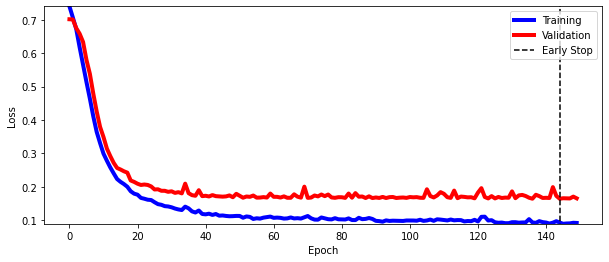

In [66]:
%matplotlib inline 
plot_learning_curve(history_multi_filter)

We can see that the training and validation loss decrease, but the validation loss is somewhat higher than the training loss. This is indicative of over-fitting to the training data. 

## Visualize the learned parameters 

Next, let's visualize the filter learned in this model

### Dense layer

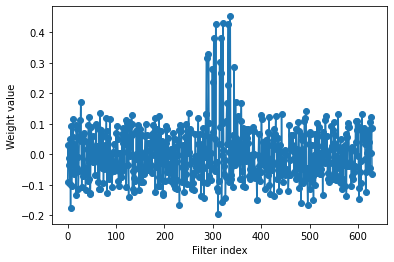

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f5872d861d0>])

In [67]:
from dragonn.vis import * 
plot_model_weights(multi_filter_keras_model)

### Convolutional layer 

In [68]:
W_conv, b_conv = multi_filter_keras_model.layers[0].get_weights()

In [69]:
W_conv.shape

(1, 10, 4, 15)

In [70]:
b_conv.shape

(15,)

Plotting simulation motifs...


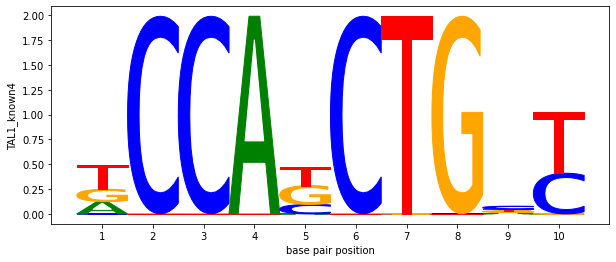

Visualizing convolutional sequence filters in SequenceDNN...


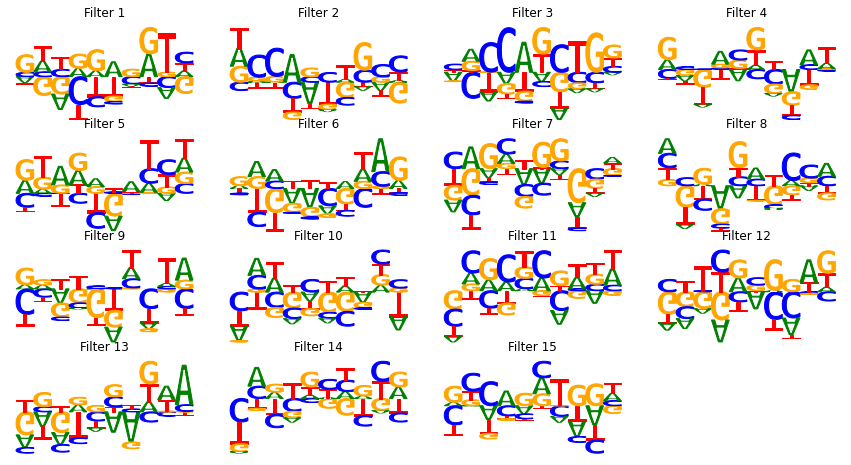

In [71]:
plot_filters(multi_filter_keras_model, simulation_data)

# Model Interpretation <a name='7'>
<a href=#outline>Home</a>


As you can see, the filters/model parameters are difficult to be interepreted directly. However, there are alternative approaches of interepreting sequences.

Let's examine a positive and negative example from our simulation data:

In [72]:
#get the indices of the first positive and negative examples in the validation data split
pos_indx=np.flatnonzero(simulation_data.y_valid==1)[0]
print(pos_indx)
pos_X=simulation_data.X_valid[pos_indx:pos_indx+1]

neg_indx=np.flatnonzero(simulation_data.y_valid==0)[0]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

2
0


### Motif Scores

In [73]:
from dragonn.utils import * 
pos_motif_scores=get_motif_scores(pos_X,simulation_data.motif_names,return_positions=True)
neg_motif_scores=get_motif_scores(neg_X,simulation_data.motif_names,return_positions=True)

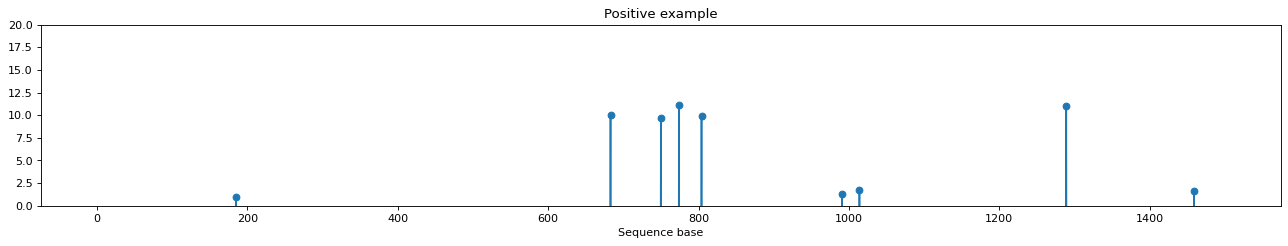

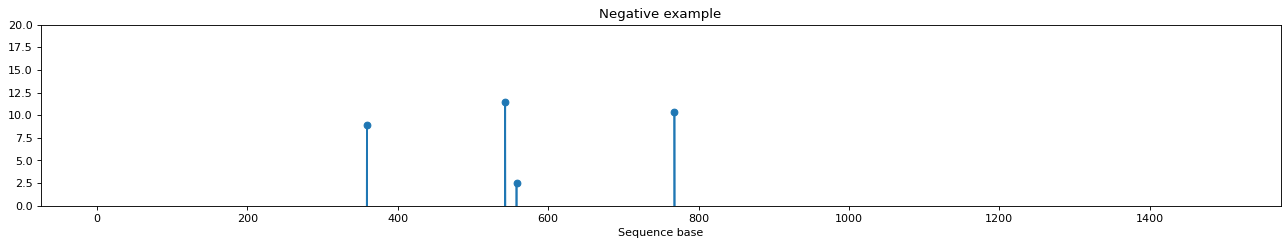

In [74]:
from dragonn.vis import * 
plot_motif_scores(pos_motif_scores,title="Positive example",ylim=(0,20))
plot_motif_scores(neg_motif_scores,title="Negative example",ylim=(0,20))

The motif scan yields a group of three high-scoring motif alignment positions at a fixed distance near the center of the sequence in the positive example. The spacing of the high-scoring motif alignments is random in the negative sequence. 

Note: If you find that your negative example is too close to the positive examle (i.e. the randomly spaced motifs happen to have a spacing close to the positive example, feel free to provide another index value to select a different negative). 

For example, you can change the code to select a negative example to the below: 


In [75]:
neg_indx=np.flatnonzero(simulation_data.y_valid==0)[10]
print(neg_indx)
neg_X=simulation_data.X_valid[neg_indx:neg_indx+1]

20


### *In silico* mutagenesis 

To determine how much each position in the input sequence contrinbutes to the model's prediction, we can perform saturation mutagenesis on the sequence. For each position in the input sequence, we introduce each of the four possible bases A, C, G, T and quantify the effect on the model's predictions.

*In silico* mutagenesis entails measuring the effect of a given base pair on the model's prediction of accessibility. The following algorithm is used: 

1. At each position in the input sequence, the reference allele is mutated to each of three possible alternate alleles, and the model predictions with the alternate alleles are obtained. 

2. The logit values for the reference allele are subtracted from the logit values for each of the 4 alleles. (This means that a difference of 0 will be obtained for the reference allele). We refer to these differences in logit at each position between the reference and alternate alleles as the ISM values. ISM values are computed in logit space to avoid any saturation effects from passing the logits through a sigmoid function. 

3. For each position, subtract the mean ISM value for that position from each of the 4 ISM values. 

4. Plot the 4xL heatmap of mean-normalized ISM values 

5. Plot the reference sequence bases weighted by the highest magnitude ISM score. 

In [76]:
pos_X.shape

(1, 1, 1500, 4)

In [77]:
from dragonn.interpret.ism import *
ism_pos=in_silico_mutagenesis(multi_filter_keras_model,pos_X,0)
ism_neg=in_silico_mutagenesis(multi_filter_keras_model,neg_X,0)

ISM: task:0 sample:0
ISM: task:0 sample:0


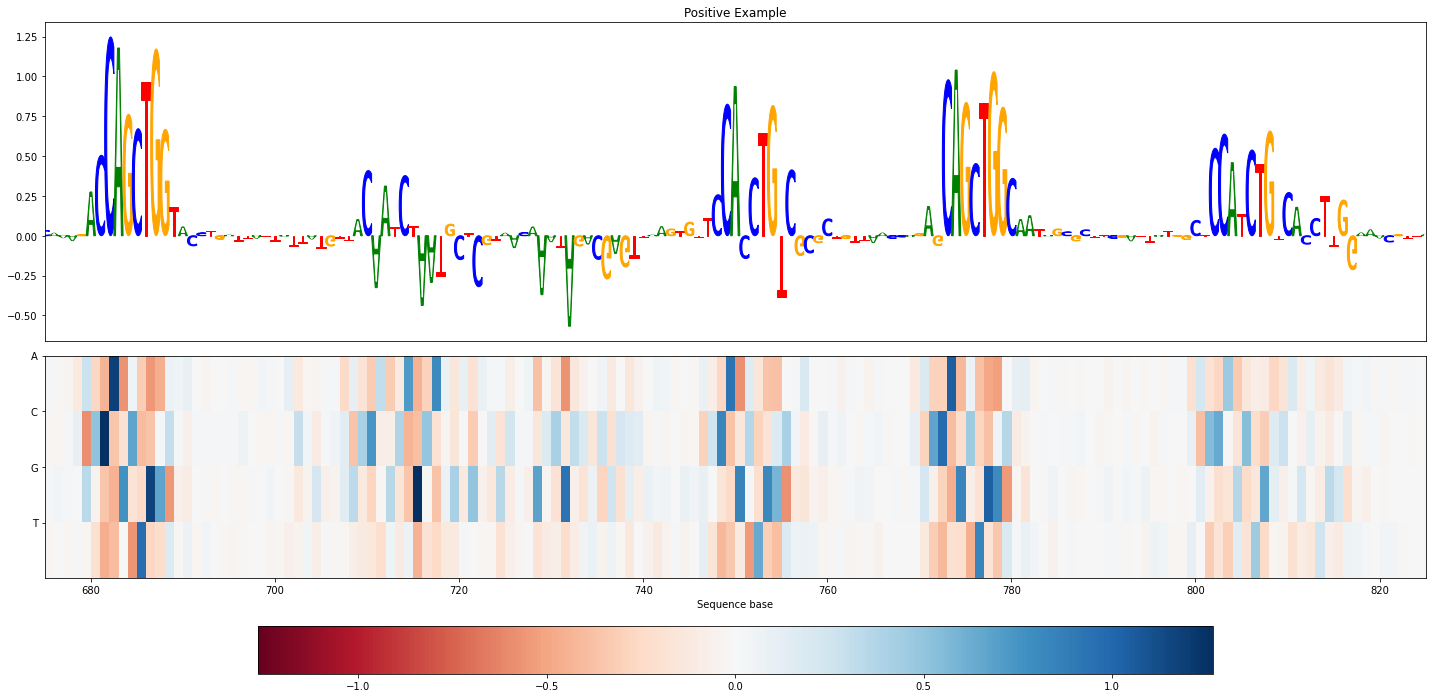

In [78]:
%matplotlib inline
from dragonn.vis import * 

# create discrete colormap of ISM scores 
#zoom into the central 150 bases of the sequence 
plot_ism(ism_pos,pos_X,title="Positive Example",xlim=(675,825))


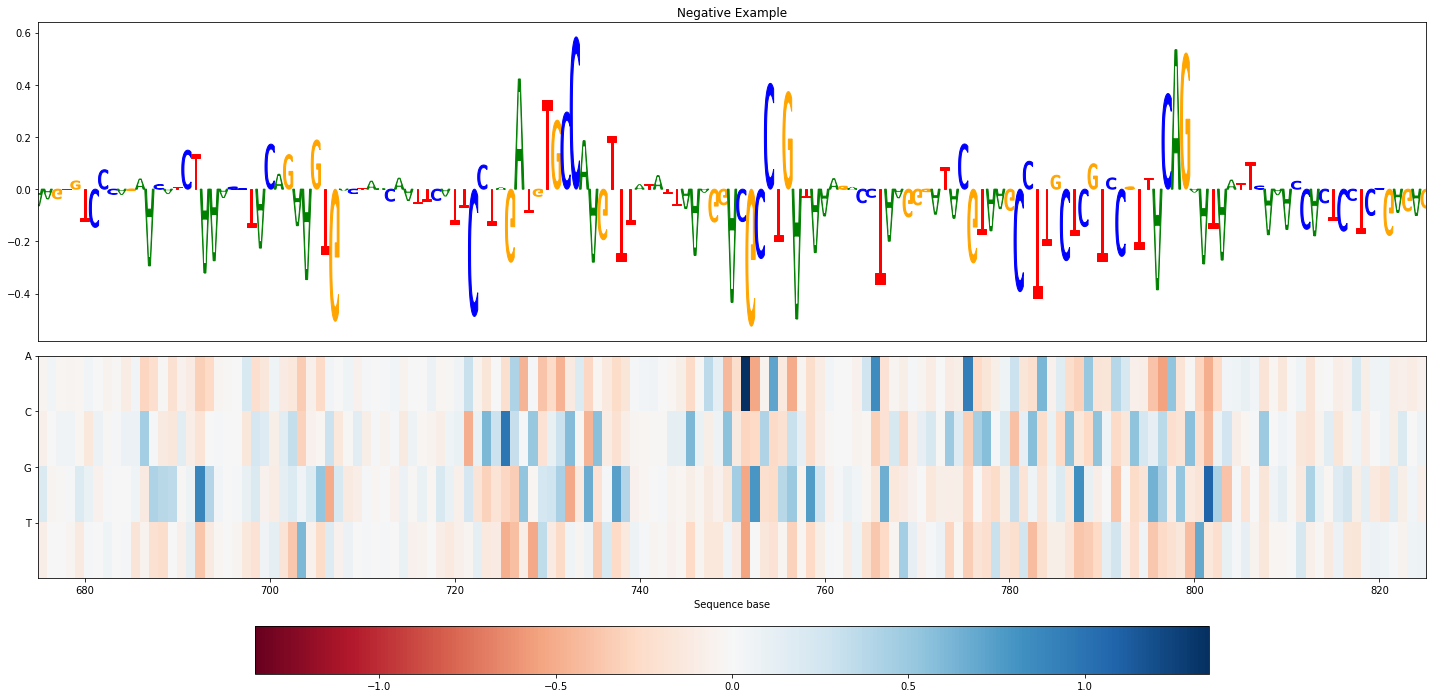

In [79]:

plot_ism(ism_neg,neg_X,title="Negative Example",xlim=(675,825))

We see clear TAL1 motif patterns emerging for the positive example in the central 150 bases of the input sequence; we do not see clear TAL1 patterns in the central 150 bases of the sequence for the negative example. 

### Gradient x Input 

Consider a neural net being a function: $f(x_1, ..., x_N; w) = y$

One way to tell whether the input feature is important is to compute the gradient of the function with respect to (w.r.t.) model input: $\frac{\partial f}{\partial x_i}$

This approach is called saliency maps: "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", by Karen Simonyan, Andrea Vedaldi and Andrew Zisserma https://arxiv.org/pdf/1312.6034.pdf

In genomics, we typically visualize only gradients for bases observed in the sequence (called input masked gradients or input*grad).

In [5]:
from dragonn.interpret.input_grad import * 
gradinput_pos=input_grad(multi_filter_keras_model,pos_X)
gradinput_neg=input_grad(multi_filter_keras_model,neg_X)

ModuleNotFoundError: ignored

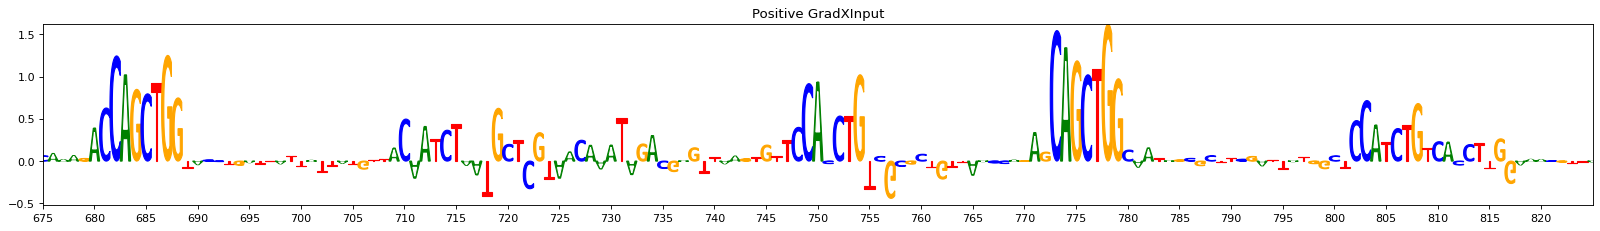

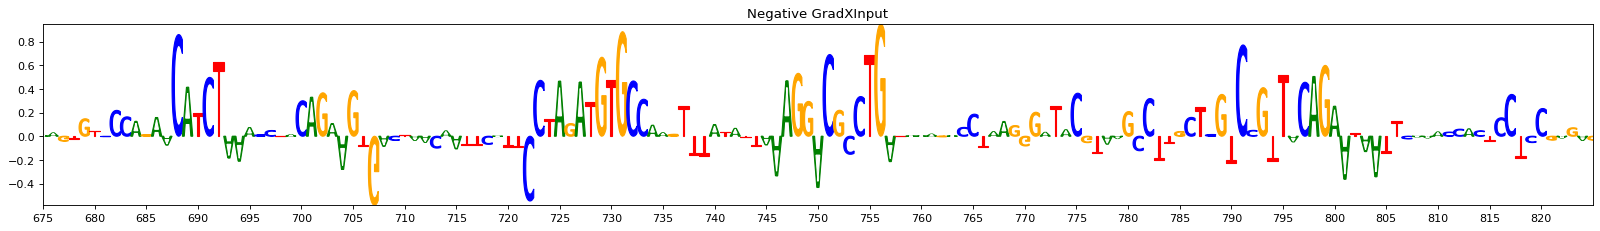

In [81]:
from dragonn.vis import plot_seq_importance
plot_seq_importance(gradinput_pos,pos_X,title="Positive GradXInput",xlim=(675,825))
plot_seq_importance(gradinput_neg,neg_X,title="Negative GradXInput",xlim=(675,825))


This confirms what we observed with the ISM analysis -- the positive example contains TAL1 motifs in the central 150 base pairs; the negative example does not. 


### DeepLIFT

DeepLIFT (cite paper) is another approach to infer the contribution or importance of individual nucleotides in a specific input sequence to its predicted out. While gradients measure the sensitivity of the output to infinitesimal changes in the input, DeepLIFT scores quantify the sensitivity of the output to finite changes in the input. Specifically, the DeepLIFT algorithm backpropagates a score (analogous to gradients) which is based on comparing the activations of all the neurons in the network for the actual input sequence to those obtained when using neutral ‘reference’ sequences. We use dinucleotide-shuffled versions of any input sequence as reference sequences.

[DeepLIFT](https://arxiv.org/pdf/1605.01713v2.pdf) allows us to obtain scores for specific sequence indicating the importance of each position in the sequence. DeepLIFT can accept a custom reference. For our purposes, we provide a dinucleotide-shuffled reference. 

We can now load the saved model for use in other applications or for further fine-tuning:

In [82]:
from dragonn.interpret.deeplift import * 
#note that the defaults for the deeplift function use 10 shuffled references per input sequence 
help(deeplift)

Help on function deeplift in module dragonn.interpret.deeplift:

deeplift(score_func, X, batch_size=200, task_idx=0, num_refs_per_seq=10, reference='shuffled_ref', one_hot_func=None)
    Arguments: 
        score_func -- deepLIFT scoring function 
        X -- numpy array with shape (n_samples, 1, n_bases_in_sample,4) or list of FASTA sequences 
        batch_size -- number of samples to interpret at once 
        task_idx -- index indicating which task to perform interpretation on 
        reference -- one of 'shuffled_ref','gc_ref','zero_ref'
        num_refs_per_seq -- integer indicating number of references to use for each input sequence if the reference is set to 'shuffled_ref';if 'zero_ref' or 'gc_ref' is used, this argument is ignored.
        one_hot_func -- one hot function to use for encoding FASTA string inputs; if the inputs are already one-hot-encoded, use the default of None 
    Returns:
        (num_task, num_samples, 1, num_bases, sequence_length) deeplift score array.

### Saving a keras model 


We save the optimal regularized multi-layer keras model to an hdf5 file that contains both the model weights and architecture.

In [83]:
multi_filter_keras_model.save("multi_filter_keras_model.hdf5")


We can now load the saved model for use in other applications or for further fine-tuning:

In [84]:
from keras.models import load_model
model=load_model("multi_filter_keras_model.hdf5")

We first use the saved model to obtain the DeepLIFT scoring function. We use a shuffled reference, with 10 shuffled reference sequences for each example. 

In [85]:
import dragonn
from dragonn.interpret import * 
help(get_deeplift_scoring_function)

Help on function get_deeplift_scoring_function in module dragonn.interpret.deeplift:

get_deeplift_scoring_function(model, target_layer_idx=-2, task_idx=0, num_refs_per_seq=10, reference='shuffled_ref', one_hot_func=None)
    Arguments: 
        model -- a string containing the path to the hdf5 exported model 
        target_layer_idx -- Layer in the model whose outputs will be interpreted. For classification models we \ 
                            interpret the logit (input to the sigmoid), which is the output of layer -2. 
                            For regression models we intepret the model output, which is the output of layer -1. 
        reference -- one of 'shuffled_ref','gc_ref','zero_ref'
        one_hot_func -- one hot function to use for encoding FASTA string inputs; if the inputs are already one-hot-encoded, use the default of None 
    Returns:
        deepLIFT scoring function



In [4]:
!pip show dragonn

In [3]:
#target_layer_idx refers to the second-to-last model layer, which is the input to the sigmoid function
#task_idx indicates that the first task in a multi-tasked model should be interpreted with DeepLIFT. Because 
# this is a single-tasked model, the task index will be 0 in all cases. 
dl_score_func=get_deeplift_scoring_function('multi_filter_keras_model.hdf5',
                                           target_layer_idx=-2,
                                           task_idx=0,
                                           num_refs_per_seq=10,
                                           reference='shuffled_ref',
                                           one_hot_func=None)

NameError: ignored

In [ ]:
#We use the scoring function to calculate deepLIFT scores for the positive and negative examples 
dl_pos=deeplift(dl_score_func,pos_X)
dl_neg=deeplift(dl_score_func,neg_X)

In [ ]:
plot_seq_importance(dl_pos,pos_X,title="DeepLift positives",xlim=(675,825))
plot_seq_importance(dl_neg,neg_X,title="DeepLift negatives",xlim=(675,825)) 

# A multi-layer DragoNN model <a name='8'>

<a href=#outline>Home</a> 

Next, we train a 3 layer model for this task. By adding additional layers, we allow the model to learn more complex features in the sequence data, such as the spatial constraint in the spacing of the TAL1 motifs. 

However, by adding additional layers to the model, we also make it more likely that the model will overfit to the training data -- we saw that the validation loss was higher than the training loss in the single-layer multi-filter model. We anticipate that this will only be more pronounced with a multi-filter model, so we add some regularization. We regularize the 3 layer using 0.2 dropout on every convolutional layer.
![MultiLayerTraining](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/MultiLayerTraining.png?raw=1)



In [ ]:
#Define the model architecture in keras

regularized_keras_model=Sequential() 
regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))

regularized_keras_model.add(Conv2D(filters=15,kernel_size=(1,10),input_shape=simulation_data.X_train.shape[1::]))
regularized_keras_model.add(Activation('relu'))
regularized_keras_model.add(Dropout(0.2))
regularized_keras_model.add(MaxPooling2D(pool_size=(1,35)))


regularized_keras_model.add(Flatten())
regularized_keras_model.add(Dense(1))
regularized_keras_model.add(Activation("sigmoid"))

##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
regularized_keras_model.compile(optimizer='adam',
                               loss='binary_crossentropy')

regularized_keras_model.summary() 

In [ ]:
## use the keras fit function to train the model for 150 epochs with early stopping after 3 epochs 
history_regularized=regularized_keras_model.fit(x=simulation_data.X_train,
                                  y=simulation_data.y_train,
                                  batch_size=128,
                                  epochs=150,
                                  verbose=1,
                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),
                                            History(),
                                            metrics_callback],
                                  validation_data=(simulation_data.X_valid,
                                                   simulation_data.y_valid))


In [ ]:
## Use the keras predict function to get model predictions on held-out test set. 
test_predictions=regularized_keras_model.predict(simulation_data.X_test)
## Generate a ClassificationResult object to print performance metrics on held-out test set 
print(ClassificationResult(simulation_data.y_test,test_predictions))

In [ ]:
## Visualize the model's performance 
from dragonn.vis import * 
plot_learning_curve(history_regularized)

In [ ]:
regularized_keras_model.save("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

Dragonn provides a single utility function to interpret and plot model predictions through all the methodologies we have examined: 
    * Plots the motif scores (when available) to serve as a "gold standard" for interpretation
    * Plots the ISM heatmap and sequence importance track 
    * Plots the gradient x input importance track
    * Plots the DeepLIFT importance track 
    

In [ ]:
from dragonn.interpret import *
help(multi_method_interpret)

In [ ]:
#obtain the deepLIFT scoring function for interpretation 
dl_score_func_multi_layer_regularized=get_deeplift_scoring_function("TAL1.Simulation.Regularized.3ConvLayers.hdf5")

In [ ]:
from dragonn.vis import * 
pos_interpretations=multi_method_interpret(regularized_keras_model,
                                           pos_X,
                                           0,
                                           dl_score_func_multi_layer_regularized,
                                           motif_names=simulation_data.motif_names)

In [ ]:
neg_interpretations=multi_method_interpret(regularized_keras_model,
                                           neg_X,
                                           0,
                                           dl_score_func_multi_layer_regularized,
                                           motif_names=simulation_data.motif_names)

We now plot the interpretation scores for pos_X and neg_X along the full sequence as well as along the central 200 bp.

In [ ]:
plot_all_interpretations([pos_interpretations],pos_X,xlim=(675,825))

In [ ]:
plot_all_interpretations([neg_interpretations],neg_X,xlim=(675,825))

As expected, additional layers in combination with regularization via dropout lead to improved test set auPRC and decreased overfitting to the training set. 

## Training on "Real" Data: SPI1 TF CHiP-seq data from ENCODE  <a name='9'>
<a href=#outline>Home</a>
We now want to use DragoNN to train and interpret a neural network on real ENCODE TF-ChIP-seq data. We will learn to predict transcription factor binding for the SPI1 transcription factor in the GM12878 cell line (one of the Tier 1 cell lines for the ENCODE project). 
    
Having done this, we want to examine how well the model is able to predict funcational SNP effects on TF binding. We compare predicted variant effect sizes from classification and regression models against  experimental bQTL data. The bQTL data in this way serves as a "gold-standard" validation that in silico mutagenesis on the deep learning inputs leads to correct variant effect size prediction.  We  will use bQTL data  that has been intersected with SPI1 CISBP genome motif annotations. 

In [ ]:
# SPI1, optimal IDR thresholded peaks, Myers lab, hg19, GM12878 cell type 
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz https://www.encodeproject.org/files/ENCFF306SRV/@@download/ENCFF306SRV.bed.gz

#Fold change bigWig track for the SPI1 dataset: 
!wget -O SPI1.pooled.fc.bigWig https://www.encodeproject.org/files/ENCFF793RKX/@@download/ENCFF793RKX.bigWig
    
## Download "ambiguous" peak sets -- these peaks are in the optimal overlap set across replicates, but are not
## found to be reproducible at a high confidence (p<0.05) by IDR. We have calculated these in advance and download 
## them from the tutorial server 
! wget -O SPI1.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.ambiguous.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi 

    


In [ ]:
# Download bQTL experimental data for SPI1 loci 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

## Generating genome-wide classification and regression labels <a name='10'>
<a href=#outline>Home</a>

We used the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. For the sake of time, we will load the pre-generated labels in this tutorial, but the label generation code is included below if you would like to run it on your own datasets. 

seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* In the classification case, each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. The bin is labeled negative if there is no overlap with the narrowPeak. 
* In the regression case, the asinh(mean log fold change relative to the input) in the 200 bp bin is computed. 


In [ ]:
##Download pre-generated genomewide labels 
## Classification labels 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.1M.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.1M.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.classification.hdf5

## Regression labels 
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.1M.hdf5
#! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.1M.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5


If you are interested in how the labels were generated, you can run the following code: 

In [ ]:
##  Generate genome-wide classification labels 
#from seqdataloader import * 

## seqdataloader accepts an input file, which we call SPI1.tasks.tsv, with task names in column 1, corresponding
## peak files in column 2, and the signal track in column 3. In this tutorial, the task file will have a single task entry for the SPI1 TF CHiP-seq
#with open("SPI1.task.tsv",'w') as f: 
#    f.write("SPI1\tSPI1.narrowPeak.gz\tSPI1.pooled.fc.bigWig\tSPI1.ambiguous.gz\n")
#f.close() 
#!cat SPI1.task.tsv

##1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set. Also, the dataset does not
## include chromosome Y, so we exclude it as well. 

#train_set_params={
#    'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.train.classification.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':4,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'peak_summit_in_bin_classification'
#    }
#genomewide_labels(train_set_params)

##2) Validation set: Chromosome 1
#valid_set_params={'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.valid.classification.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_keep':'chr1',
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':1,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'peak_summit_in_bin_classification'
#    }
#genomewide_labels(valid_set_params)

##3) Test set: Chromosomes 2, 19 
#test_set_params={
#    'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.test.classification.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_keep':['chr2','chr19'],
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':2,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'peak_summit_in_bin_classification'
#    }
#genomewide_labels(test_set_params)


## Generate regression labels genome-wide 

##1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set 

#train_set_params={
#    'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.train.regression.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':4,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'all_genome_bins_regression'
#    }
#genomewide_labels(train_set_params)

##2) Validation set: Chromosome 1
#valid_set_params={'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.valid.regression.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_keep':'chr1',
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':1,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'all_genome_bins_regression'
#    }
#genomewide_labels(valid_set_params)

##3) Test set: Chromosomes 2, 19 
#test_set_params={
#    'task_list':"SPI1.task.tsv",
#    'outf':"SPI1.test.regression.hdf5",
#    'output_type':'hdf5',
#    'chrom_sizes':'hg19.chrom.sizes',
#    'chroms_to_keep':['chr2','chr19'],
#    'bin_stride':50,
#    'left_flank':400,
#    'right_flank':400,
#    'bin_size':200,
#    'threads':2,
#    'subthreads':4,
#    'allow_ambiguous':True,
#    'labeling_approach':'all_genome_bins_regression'
#    }
#genomewide_labels(test_set_params)


Let's examine the label files that were generated: 

In [ ]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
import pandas as pd
pd.read_hdf("SPI1.train.classification.1M.hdf5",start=0,end=1000)


We will now train genome-wide classification and regression models: 
![GenomeWideModel](https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/GenomeWideModel.png?raw=1)


## Genome-wide classification model <a name='11'>
<a href=#outline>Home</a>

In [ ]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [ ]:
from dragonn.runtime_metrics import precision, recall, specificity, fpr, fnr, fdr, f1
from keras.constraints import max_norm
from dragonn.custom_losses import ambig_binary_crossentropy
def initialize_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))
    
    #use the custom ambig_binary_crossentropy loss, indicating that a value of np.nan indicates an ambiguous label 
    loss=ambig_binary_crossentropy
    
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss=loss,
                  metrics=[precision,
                          recall,
                          specificity,
                          fpr,
                          fnr,
                          fdr,
                          f1])
    return model

We create generators for the training and validation data: 

In [ ]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.1M.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.1M.hdf5","hg19.genome.fa.gz", batch_size=256)


For the sake of time, we will train the model for 10 epochs, using 100 steps per epoch in training and validation.
**steps_per_epoch** indicates the number of batches that constitute a single epoch (recall that an epoch constitutes a full forward and backward pass of the dataset through the model before weights are updated). In practice, we often don't need to pass the full dataset through the model to constitute an epoch, especially when the dataset is very large. We can specify the epoch size with the **steps_per_epoch** argument. 

Use larger values when training an actual model -- a recommended epoch size is 100000 samples for training and 50000 for validation. 

In [ ]:
#Train the SPI1 classification model 
spi1_classification_model=initialize_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_classification=spi1_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=100, #number of batches to examine in one
                                                  validation_steps=100,
                                                  epochs=10,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=20,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
## Plot the learning curves for SPI1  
from dragonn.vis import *
plot_learning_curve(history_classification)

The training loss curve decreases gradually over the 7 epochs of training, while the validation loss drops sharply on the first epoch and then remains relatively flat. A possible explanation is that the training set is upsampled to include 10% positives in each batch, while the validation set is not upsampled and therefor has approximately 2% positives in each batch. 

In [ ]:
#We load the pre-trained SPI1 classification model for further analysis. This model was trained with the same 
# code as above, but using epochs of size 100000 rather than 100. 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5

from keras.models import load_model
from dragonn.custom_losses import * 
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "fdr":fdr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy}
spi1_classification_model=load_model("SPI1.classification.model.hdf5",custom_objects=custom_objects)

We now measure how well the model performed by calculating performance metrics on the test splits across the whole genome. 

In [ ]:
from dragonn.generators import * 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                         "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=500,
                                         tasks=['SPI1'])


In [ ]:
spi1_test_classification_predictions=spi1_classification_model.predict_generator(spi1_test_classification_gen,
                                                                                 max_queue_size=5000,
                                                                                 workers=20,
                                                                                 use_multiprocessing=True,
                                                                                 verbose=1)

In [ ]:
spi1_test_classification_labels=spi1_test_classification_gen.data
print(spi1_test_classification_predictions.shape) 
print(spi1_test_classification_labels.shape)

In [ ]:
#remove nans, as they corresponnd to ambiguous values 
nan_indices=np.isnan(spi1_test_classification_labels.values.astype(bool))

In [ ]:
nan_indices.shape

In [ ]:
spi1_test_classification_labels=spi1_test_classification_labels[~nan_indices]
spi1_test_classification_predictions=np.expand_dims(spi1_test_classification_predictions[~nan_indices],axis=1)

In [ ]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_labels.values.astype(bool),
                           spi1_test_classification_predictions))

## Genome-wide regression model <a name='12'>
<a href=#outline>Home</a>

In [ ]:
from dragonn.custom_losses import ambig_mean_squared_error
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))

    loss=ambig_mean_squared_error
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss=loss)
    return model

We upsample bins with signal greater than 0.1. 

In [ ]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.1M.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=0.1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.1M.hdf5","hg19.genome.fa.gz",upsample_thresh=0.1)


In [ ]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=100,
                                                  validation_steps=100,
                                                  epochs=10,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

In [ ]:
from dragonn.vis import *
plot_learning_curve(history_regression)

In [ ]:
#We load a regression model that has been trained on epochs of size 100000 until the early stopping criterion
# was met. 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5

from keras.models import load_model
from dragonn.custom_losses import * 
from dragonn.metrics import * 
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "fdr":fdr,
                "precision":precision,
                "f1":f1,
                "ambig_mean_squared_error":ambig_mean_squared_error}
spi1_regression_model=load_model("SPI1.regression.model.hdf5",custom_objects=custom_objects)

In [ ]:
#Get predictions on the test set 
from dragonn.generators import * 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])

In [ ]:
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                                         max_queue_size=5000,
                                                                         workers=40,
                                                                         use_multiprocessing=True,
                                                                         verbose=1)

In [ ]:
spi1_test_regression_labels=spi1_test_regression_gen.data
spi1_test_regression_predictions=np.expand_dims(spi1_test_regression_predictions,axis=1)

In [ ]:
#remove nans, as they corresponnd to ambiguous values 
spi1_test_regression_labels=spi1_test_regression_labels[~nan_indices]
spi1_test_regression_predictions=spi1_test_regression_predictions[~nan_indices]

In [ ]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_labels,spi1_test_regression_predictions)
corr_spearman=spearmanr(spi1_test_regression_labels,spi1_test_regression_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

In [ ]:
## find the indices of the non-zero coverage bins 
nonzero_bins=spi1_test_regression_labels.max(axis=1)>0

In [ ]:
# Calculate the spearman and pearson correlation, restricted to non-zero bins 
corr_pearson_nonzero_bins=pearsonr(spi1_test_regression_labels[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
corr_spearman_nonzero_bins=spearmanr(spi1_test_regression_labels[nonzero_bins],spi1_test_regression_predictions[nonzero_bins])
print("Pearson correlation on test set:"+str(corr_pearson_nonzero_bins))
print("Spearman correlation on test set:"+str(corr_spearman_nonzero_bins))

## Genome-wide interpretation of true positive predictions in SPI1 <a name='13'>
<a href=#outline>Home</a>

### Classification Model

In [ ]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
true_pos_spi1=spi1_test_classification_labels[spi1_test_classification_labels.values*spi1_test_classification_predictions > 0.9]


In [ ]:
true_pos_spi1.shape

In [ ]:
from dragonn.utils import one_hot_from_bed
interpretation_input_classification_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
interpretation_input_classification_spi1.shape

We interpret a high-confidence true  positive example with ISM, gradient analysis, and DeepLIFT. 

In [ ]:
classification_positive_example= np.expand_dims(interpretation_input_classification_spi1[0],axis=1)


In [ ]:
from dragonn.interpret import * 

#we obtain the deepLIFT function to use with this model 
deeplift_score_func_classification=get_deeplift_scoring_function("SPI1.classification.model.hdf5")

In [ ]:
from dragonn.interpret import * 

pos_interpretations=multi_method_interpret(spi1_classification_model,
                                           classification_positive_example,
                                           0,
                                           deeplift_score_func_classification)

In [ ]:
#let's zoom in to the central 200 bp 
from dragonn.vis import * 
plot_all_interpretations([pos_interpretations],classification_positive_example,xlim=(400,600))

If we query the sequence of the observed motif in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we should find  that the motif is a good match for SPIB. 
An example you might observe is below: 
<img src="https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/SPI1.Tut4.png?raw=1" alt="SPI12TomTom" width="400"/>

### Regression model 

In [ ]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence 
#get the true positive predictions 
true_pos_regression=spi1_test_regression_labels[(spi1_test_regression_labels.values*spi1_test_regression_predictions)>4]
true_pos_regression.shape

In [ ]:
interpretation_input_regression_spi1=one_hot_from_bed([i for i in true_pos_regression.index],"hg19.genome.fa.gz")
interpretation_input_regression_spi1.shape

In [ ]:
regression_positive_example= np.expand_dims(interpretation_input_regression_spi1[0],axis=1)

In [ ]:
#get the deeplift scoring function for regression
deeplift_score_func_regression=get_deeplift_scoring_function("SPI1.regression.model.hdf5",target_layer_idx=-1)

In [ ]:
regression_interpretations=multi_method_interpret(spi1_regression_model,
                                           regression_positive_example,
                                           0,
                                           deeplift_score_func_regression)

In [ ]:
plot_all_interpretations([regression_interpretations],regression_positive_example,xlim=(500,600))

The motif learned by the regression model matches the canonical SPI1 motif as well. 


## SPI1 Binding Quantitative Trait Loci (bQTL) Data <a name='14'>
    
<a href=#outline>Home</a>

A study by Fraser et al (https://www.cell.com/fulltext/S0092-8674(16)30339-7) identified several thousand cis-acting bQTL's that affect the binding of SPI1 transcription factors in humans. We examine how effective our models are at recognizing these bQTLs. 

### Read in and annotate the bQTL dataset <a name='a'>
<a href=#outline>Home</a>


In [ ]:
## Download the bQTL dataset 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

In [ ]:
#Read in the bQTL dataframe
bqtls=pd.read_csv("SPI1.bQTLs.txt.gz",header=0,sep='\t')
bqtls.head

In [ ]:
#Calculate the number of bQTL's
print(bqtls.shape)
n_bqtls=bqtls.shape[0]

In [ ]:
#sort the bqtl's by p-value 
bqtls=bqtls.sort_values(by=['pvalue'])

We now annotate the bQTL's with the false discovery rate, the mean fold change bigWig signal in the bQTL region, and the logratio fo the post-CHIP frequency relative to the pre-CHIP frequency. Some of these operations are time-consuming, particularly the calculation of the mean fold change bigWig signal. Hence,we have pre-run them. If you would like to execute these operations, uncomment the code cells below. 

In [ ]:
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.additional.metrics.txt.gz
bqtls=pd.read_csv("SPI1.bQTLs.additional.metrics.txt.gz",header=0,sep='\t')
bqtls.head

In [ ]:
##Calculate the Benjamini-Hochberg FDR 
#bqtls['FDR']=1.0
#for index,row in bqtls.iterrows(): 
#    row['FDR']=min(row['FDR'],row['pvalue']*n_bqtls/(index+1))

In [ ]:
## Calculate logratio of the Post-CHIP frequency to the pre-CHIP frequency
#bqtls['logratio']=np.log((bqtls['POSTfreq']+.01)/(bqtls['prechipfreq']+0.01))

In [ ]:
## IMPORTANT! Convert the bQTL coordinates from 1-indexing to 0-indexing
#bqtls['start']=bqtls['position']-1
#bqtls['end']=bqtls['position']

In [ ]:
## Calculate the mean fold change bigWig signal within the 200 bp region 
## centered on the bQTL

##initialize the field within the Pandas dataframe with default value of 0
#bqtls['mean_chipseq_fc']=0

##use the pyBigWig library to calculate the mean fold change bigWig signal 
##within the 200 bp region centered at the bQTL 
#import pyBigWig 
#bigwig_fh = pyBigWig.open("SPI1.pooled.fc.bigWig")
#for index,row in bqtls.iterrows():
#    values = bigwig_fh.values(row['Chr'],
#                              row['end']-100,
#                              row['end']+100,
#                              numpy=True)
#    row['mean_chipseq_fc'] = np.mean(values)
#    if (index%1000 == 0):
#        print("Done",index)

In [ ]:
##Let's save the augmented bQTL data frame so we can resume from 
## this point in the analysis more easily. 
#bqtls.to_csv("SPI1.bQTLs.additional.metrics.txt.gz",
#            sep='\t',
#            header=True,
#            index=False,
#            compression='gzip')

### DNN predictions for Post and Alt alleles within the bQTL dataset  <a name='b'>
<a href=#outline>Home</a>

We would like to obtain  predictions for the reference and alternate alleles at each bQTL. Because we will visualize the difference in predictions for the reference and alternate bQTL alleles, we will operate in logit space -- the layer in the model whose output feeds into the final sigmoid layer. We do this because calculating the logratio of model predictions in logit space is more correct than subtracting probabilities from the model's final sigmoid output layer. 

Consequently, we first obtain the logits (for the classification model) and pre-activations (for the regression model).

In [ ]:
# we create a new model that wraps around "spi1_classification_model" and provides the logits (layer -2)
from keras.models import Model 
target_layer_idx=-2
classification_preact_model=Model(inputs=spi1_classification_model.input,
                   outputs=spi1_classification_model.layers[target_layer_idx].output)


In [ ]:
#Create a model to return the preactivation (input to the final ReLU) for the regression model. 
target_layer_idx=-1
regression_preact_model=Model(inputs=spi1_regression_model.input,
                   outputs=spi1_regression_model.layers[target_layer_idx].output)


In [ ]:
# get model predictions for bQTLs 
from dragonn.generators import * 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [ ]:
bqtl_post_classification_logits=classification_preact_model.predict_generator(bqtl_post_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)


In [ ]:
bqtl_alt_classification_logits=classification_preact_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)


bqtl_post_classification_truth=bqtl_post_gen.data['pvalue']

In [ ]:
# re-initialize the generators for use in obtaining 
#predictions from regression models. 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [ ]:
bqtl_post_regression_preacts=regression_preact_model.predict_generator(bqtl_post_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)

In [ ]:
bqtl_alt_regression_preacts=regression_preact_model.predict_generator(bqtl_alt_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)

Let's augment the bQTL dataframe with the model predictions. Let's summarize the predictions we have generated on the bQTL dataset: 

* Classification model logits for the POST allele 
* Classification model logits for the ALT allele 

* Regression model pre-activations for the POST allele 
* Regression model pre-activations for the ALT allele 



In [ ]:
bqtls['post_classification_logits']=bqtl_post_classification_logits
bqtls['alt_classification_logits']=bqtl_alt_classification_logits
bqtls['post_regression_preacts']=bqtl_post_regression_preacts
bqtls['alt_regression_preacts']=bqtl_alt_regression_preacts



We want to calibrate out model predictions to follow the same distribution as the inputs. We can do this with Platt scaling for the classifiation model and isotonic regression for the regression models. We do not cover these techniques in this tutorial, but we provide the calibrated predictions in an augmented SPI1 bQTL dataframe: 

In [ ]:
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.augmented.txt.gz
bqtls=pd.read_csv("SPI1.bQTLs.augmented.txt.gz",header=0,sep='\t')
bqtls.head

## Compare model predictions on POST and ALT alleles  <a name='c'>
<a href=#outline>Home</a>


We now assess whether the model predictions of accessibility change for significant bQTL's when the reference allele is replaced with the alternate allele in the input sequence. We also compare the distribution of reference vs alternate predictions for the set of significant bQTLS to the corresponding distribution for the set of non-significant bQTLs. 

First, we must select comparable subsets of non-significant and significant bQTLs from the bQTL dataset. For our purposes, the sets are comparable if they have similar distributions of accessibility predictions, where predictions are defined as the max of the reference and alternate allele predictions. To ensure that we are comparing such "matched" subsets, we perform the following steps:  

In [ ]:
#We define a temporary field in the bqtl dataframe to store the maximum 
# of the calibrated classification predictions for the alternate and reference 
# alleles 
bqtls['max_classification_predictions']=bqtls[["post_classification_logits",
                                               "alt_classification_logits"]].max(axis=1)

#We define another temporary field to store the maximum of the 
# calibrated regression predictions for the alternate and reference alleles 
bqtls['max_regression_predictions']=bqtls[['post_regression_preacts',
                                          'alt_regression_preacts']].max(axis=1)


In [ ]:
significant_bqtls=bqtls[bqtls['pvalue']<=5e-5]
non_significant_bqtls=bqtls[bqtls['pvalue']==1]


In [ ]:
significant_bqtls.shape

In [ ]:
non_significant_bqtls.shape

We define a helper function to sample bQTLS from the bQTL dataset to match another subset of bQTLS according to a user-specified attr_name. This function will allow us to compare the accessibility predictions for significant bQTLS with the non-significant bQTLS. 

In [ ]:
from plotnine import * 
def plot_distribution(bqtls_to_match,matched_sampled_bqtls,attr_name):
    toplot=pd.DataFrame({"bqtls_to_match":bqtls_to_match[attr_name],
                        "matched_sampled_bqtls":matched_sampled_bqtls[attr_name]})
    toplot=toplot.melt()
    print((ggplot(toplot,aes(x="value",group="variable",color="variable",fill="variable"))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")))

    print((ggplot(bqtls_to_match,aes(x=attr_name))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")
     +ggtitle("bqtls_to_match")))

    print((ggplot(matched_sampled_bqtls,aes(x=attr_name))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")
     +ggtitle("matched_sampled_bqtls")))



def sample_matched_bqtls(bqtls_to_match, bqtls_to_sample, attr_name):
    #sort bqtls_to_sample by attr_name
    sorted_bqtls_to_sample=bqtls_to_sample.sort_values(by=[attr_name])
    sorted_bqtls_to_sample_vals = sorted_bqtls_to_sample[attr_name]
    
    bqtls_to_match_vals = bqtls_to_match[attr_name]
    
    #find indices in the bqtls_to_match_vals Series that are close in value to corresponding entries 
    # from sorted_bqtls_to_sample_vals
    searchsorted_indices = np.searchsorted(a=np.array(sorted_bqtls_to_sample_vals), 
                                           v=np.array(bqtls_to_match_vals))
    
    matched_sampled_bqtls_indices = set()
    
    for idx in searchsorted_indices:
        #shift the index until you find one that isn't taken
        shift = 1
        while (idx in matched_sampled_bqtls_indices or idx==len(sorted_bqtls_to_sample)):
            if idx == len(sorted_bqtls_to_sample):
                shift = -1
            idx += shift
        if (idx < 0 or idx > len(sorted_bqtls_to_sample)):
            print(idx)
        matched_sampled_bqtls_indices.add(idx)
    
    matched_sampled_bqtls = sorted_bqtls_to_sample.iloc[list(matched_sampled_bqtls_indices)]
    
    plot_distribution(bqtls_to_match,matched_sampled_bqtls,attr_name)
        
    return matched_sampled_bqtls

We now utilize the "sample_matched_bqtls" helper function to select matched subsets of significant and non-significant bQTLs by model prediction values 

In [ ]:
matched_bqtls_maxaltpost = sample_matched_bqtls(bqtls_to_match=significant_bqtls,
                                                     bqtls_to_sample=non_significant_bqtls,
                                                     attr_name="max_classification_predictions")

We have now verified that the distribution of max(alt allele prediction, ref allele predictions) for the significant bQTL subset matches the corresponding distribution for the non-significant bQTL subset. 

Our next step is to generate a scatterplot examining the model predictions for reference vs alternate alleles within the matched significant and non-significant subsets: 

In [ ]:
#concatenate the subset of significant bQTL's and the matched subset of non-significant bQTL's for visualization on the 
# same plotting axes 
significant_bqtls['Significant_bQTL']=True
matched_bqtls_maxaltpost['Significant_bQTL']=False 
to_score_bqtls=pd.concat([significant_bqtls,matched_bqtls_maxaltpost],axis=0)

In [ ]:
#concatenate the subset of significant bQTL's and the matched subset of non-significant bQTL's for visualization on the 
# same plotting axes 
significant_bqtls['Significant_bQTL']=True
matched_bqtls_maxaltpost['Significant_bQTL']=False 
to_score_bqtls=pd.concat([significant_bqtls,matched_bqtls_maxaltpost],axis=0)

In [ ]:
significant_to_score_bqtls=to_score_bqtls[to_score_bqtls['Significant_bQTL']==True]
insignificant_to_score_bqtls=to_score_bqtls[to_score_bqtls['Significant_bQTL']==False]


In [ ]:
#use the plotnine plotting library to generate a scatterplot of calibrated classification predictions 
# for the POST and ALT alleles within the significant and matched non-significant bQTL subsets. 


print((ggplot(significant_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions"))
             +geom_point(alpha=0.3,color="#0000FF")
             +xlab("POST classification predictions")
             +ylab("ALT classification predictions")
             +theme_bw()
             +ggtitle("Significant bQTLS")))

print((ggplot(insignificant_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions"))
             +geom_point(alpha=0.3,color="#FF0000")
             +xlab("POST classification predictions")
             +ylab("ALT classification predictions")
             +theme_bw()
             +ggtitle("Non-Significant bQTLS")))


As expected, we observe a much higher fraction of significant bQTL's deviating from the diagonal of the plot relative to the non-significant bQTL's. This makes sense -- if a bQTL lies along the diagonal, then the model prediction for the POST allele is very close to the prediction for the ALT allele (i.e. the SNP does not have a strong effect on prediction of accessibility). However, when a bQTL lies far from the diagonal, the model predicts a different probability of chromatin accessibility for the POST and ALT alleles -- i.e. the SNP is disrupting TF binding. 

## bQTL dataset motif scan with HOCOMOCO SPI1 motif  <a name='d'>
<a href=#outline>Home</a>

Our next step is to annotate the to-score bQTLs with the fasta sequence around them and do motif scoring to determine whether the SPI1 motif is driving the change in model predictions for the reference and altenate alleles.

In [ ]:
#We save the "to_score" bQTL subset to an output file so we can reproduce this analysis in the future starting from the 
# motif scoring step. 
to_score_bqtls.to_csv("SPI1.bQTLs.toScore.txt.gz",
                      sep='\t',
                      index=False,
                      compression="gzip")
num_to_score=to_score_bqtls.shape[0]

In [ ]:
#We use a flank size of 10 on either side of the bQTL 
flank_size=10

#Once again, we initialize our POST and ALT generators for the bQTL dataset, focusing only on the significant bQTLs and 
# our matched non-significant subset. 
#We use a hack where we set the batch size equal to the number of bQTL's to be scored so we get the one-hot-encoding 
#for all bQTL's simultaneously in one batch 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                            "hg19.genome.fa.gz",
                            "POSTallele",
                            flank_size=flank_size,
                            batch_size=num_to_score)
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                           "hg19.genome.fa.gz",
                           "ALTallele",
                           flank_size=flank_size,
                           batch_size=num_to_score)



We now load the SPI1 count matrix from the [HOCOMOCO](http://hocomoco11.autosome.ru/motif/SPI1_HUMAN.H11MO.0.A) database. 

In [ ]:
! [[ -e SPI1.pcm ]] || curl http://hocomoco11.autosome.ru/final_bundle/hocomoco11/full/HUMAN/mono/pcm/SPI1_HUMAN.H11MO.0.A.pcm > SPI1.pcm

In [ ]:
! cat SPI1.pcm

In [ ]:
spi1_pcm = np.array([
                [float(x) for x in row.rstrip().split("\t")]
                for (i,row) in enumerate(open("SPI1.pcm")) if i > 0]).transpose((1,0))

In [ ]:
spi1_pcm

In [ ]:
#add a pseudocount for motif normalization 
pseudocount=10e-4
spi1_pcm+=pseudocount
spi1_pcm

In [ ]:
#calculate the frequency matrix from the count matrix 
#print row-sums 
np.sum(spi1_pcm,axis=0)
#normalize by row-sums 
spi1_pfm=spi1_pcm/np.sum(spi1_pcm,axis=0)
#sanity-check that the row-sums for the position frequency matrix (pfm) are 1 
np.sum(spi1_pfm,axis=0)

In [ ]:
#plot the pwm 
plot_bases(spi1_pfm.transpose(),figsize=(6,3))

In [ ]:
#plot the reverse complement of the pwm 
from dragonn.utils import reverse_complement
plot_bases(reverse_complement(spi1_pfm.transpose()),figsize=(6,3))

Note that the high confidence true positive SPI1 peaks we interpreted have deepLIFT score profiles resembling the 
reverse complement SPI1B motif. 

For each SNP in our bQTL scoring subset, we compute the maximum motif scan score along the 20 bp flanking the reference allele and the alternate allele. In this motif scan, we consider both the motif logo and the reverse complement of the motif logo. We then calculate the difference in the maximum motif score for the alternate allele and the reference allele. These scores should be higher for the significant subset of bQTLs compared to the non-significant subset of bQTLs. We verify that this is indeed the case. 

In peforming the motif scan, we normalize relative to the gc content of the SPI1 peaks in our dataset. Let's calculate this value.

In [ ]:
# We should have the SPI1.narrowPeak.gz file already downloaded, but just in case  here is the link to download 
# it again. 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.narrowPeak.gz
from dragonn.utils import allele_freqs_from_bed
spi1_peak_freqs=allele_freqs_from_bed("SPI1.narrowPeak.gz","hg19.genome.fa.gz")

In [ ]:
# a, c, g, t frequqencies 
print(spi1_peak_freqs)
GC_fraction=spi1_peak_freqs[1]+spi1_peak_freqs[2]
print(GC_fraction)

In [ ]:
#Get the maximum sequence SPI1B scan scores for the reference allele 
to_score_bqtls['scan_post_scores']=np.max(
    get_motif_scores(
        bqtl_post_gen[0],
        ["SPI1B"],
        GC_fraction=GC_fraction,
        pfm=spi1_pfm,
        include_rc=True)
    ,axis=2).squeeze()

In [ ]:
#Get the maximum sequence SPI1B scan scores for the alternate alelle 
to_score_bqtls['scan_alt_scores']=np.max(
    get_motif_scores(
        bqtl_alt_gen[0],
        ["SPI1B"],
        GC_fraction=GC_fraction,
        pfm=spi1_pfm, 
        include_rc=True)
    ,axis=2).squeeze()

In [ ]:
#Compute the scan score delta for the reference allele - alternate allele 
to_score_bqtls['scan_delta']=to_score_bqtls['scan_post_scores']-to_score_bqtls['scan_alt_scores']


We summarize our findings below: 

### bQTL interpretation summary: deep learning models vs motif scan  <a name='e'>
<a href=#outline>Home</a>

#### Motif scan 

In [ ]:
#We plot the motif scan scores for the POST and ALT alleles: 
significant_to_score_bqtls=to_score_bqtls[to_score_bqtls['Significant_bQTL']==True]
insignificant_to_score_bqtls=to_score_bqtls[to_score_bqtls['Significant_bQTL']==False]

print((ggplot(significant_to_score_bqtls,aes(x="scan_post_scores",
                y="scan_alt_scores"))
             +geom_point(alpha=0.3,color="#0000FF")
             +xlab("POST allele motif scan score for SPI1B")
             +ylab("ALT allele motif scan score for SPI1B")
             +ggtitle("Significant bQTLs")
             +theme_bw()))
print((ggplot(insignificant_to_score_bqtls,aes(x="scan_post_scores",
                y="scan_alt_scores"))
             +geom_point(alpha=0.3,color="#FF0000")
             +xlab("POST allele motif scan score for SPI1B")
             +ylab("ALT allele motif scan score for SPI1B")
             +ggtitle("Non-Significant bQTLs")
             +theme_bw()))


Recall that we defined the bQTL logratio as the  logratio of the Post-CHIP frequency to the pre-CHIP frequency. Plotting the bQTL logratio vs the delta of the PWM scan score gives: 


In [ ]:
print((ggplot(to_score_bqtls,aes(x="logratio",
                y="scan_delta",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele motif scan score - ALT allele motif scan")
             +theme_bw()))


#### Calibrated classification model predictions 

In [ ]:
#We plot the calibrated classification model predictions for the POST and ALT alleles
# (we examined this plot above, it is reproduced here for context with the other comparisons)

print((ggplot(significant_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions"))
             +geom_point(alpha=0.3,color="#0000FF")
             +xlab("POST allele calibrated classification model prediction")
             +ylab("ALT allele calibrated classification model prediction")
             +ggtitle("Signicant bQTLs")
             +theme_bw()))
print((ggplot(insignificant_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions"))
             +geom_point(alpha=0.3,color="#FF0000")
             +xlab("POST allele calibrated classification model prediction")
             +ylab("ALT allele calibrated classification model prediction")
             +ggtitle("Non-Signicant bQTLs")
             +theme_bw()))

In [ ]:
#We plot the logratio for the bQTLs vs the delta in logit space 

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':to_score_bqtls['Significant_bQTL'],
                      'logratio':to_score_bqtls['logratio'],
                     'delta_classification_predictions':
                      to_score_bqtls['post_classification_logits']-
                      to_score_bqtls['alt_classification_logits']})

print((ggplot(to_plot,aes(x="logratio",
                y="delta_classification_predictions",
                color="Significant_bQTL",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele classification logit - \nALT allele classification logit")
             +theme_bw()))


Finally, we restrict our analysis to the subset of bQTL's where the model's prediction changed most dramatically betwen the POST and ALT alleles. For this purpose, we subset the to_score_bqtls to those bQTL's where : 

* POST calibrated prediction > 0.7 and ALT calibrated prediction < 0.3
or 
* POST calibrated prediction < 0.3 and ALT calibrated prediction > 0.7 

In [ ]:
condition1=(to_score_bqtls['post_classification_predictions']>0.7) & (to_score_bqtls['alt_classification_predictions']<0.3)
condition2=(to_score_bqtls['post_classification_predictions']<0.3) & (to_score_bqtls['alt_classification_predictions']>0.7)
to_keep=condition1 | condition2 
confident_to_score_bqtls=to_score_bqtls[to_keep]

In [ ]:
confident_to_score_bqtls.shape

In [ ]:
#We plot the calibrated classification model predictions for the POST and ALT alleles
# (we examined this plot above, it is reproduced here for context with the other comparisons)

print((ggplot(confident_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.5)
             +xlab("POST allele calibrated classification model prediction")
             +ylab("ALT allele calibrated classification model prediction")
             +scale_color_manual(values=["#FF0000","#0000FF"])
             +theme_bw()))

In [ ]:
#We plot the logratio for the bQTLs vs the delta in calibrated predictions 

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':confident_to_score_bqtls['Significant_bQTL'],
                      'logratio':confident_to_score_bqtls['logratio'],
                     'delta_classification_predictions':
                      confident_to_score_bqtls['post_classification_logits']-
                      confident_to_score_bqtls['alt_classification_logits']})

print((ggplot(to_plot,aes(x="logratio",
                y="delta_classification_predictions",
                color="Significant_bQTL",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele classification logit  - \nALT allele classification logit")
             +scale_color_manual(values=["#FF0000","#0000FF"])
             +theme_bw()))

Our visualizations of the logratio values vs the delta in motif scan scores and model predictions are quite informative. For the significant bQTL's, we see a positive correlation between logratio and delta in model predictions. However, this correlation is nearly non-existent for the motif scan, suggesting the higher sensitivity of the deep learning model. Let's test this out on a low-affinity transcription factor example: 


## Deep learning models are able to identify low-affinity TF-binding sites missed by motif scanning. <a name='15'>
<a href=#outline>Home</a>

Let's examine the region **chr5:107857257:107857288**. We have a highly significant bQTL within that region: 

In [ ]:
to_score_bqtls[(to_score_bqtls['Chr']=="chr5") & (to_score_bqtls['position']>107857256) & (to_score_bqtls['position']<107857288)]

Let's extract the one-hot-encoded 1kb region centered at this position and 

1) interpret the region with our deep learning models

2) scan the region with the canonical SPI1 motif

We can compare how the two approaches perform. 

In [ ]:
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                            "hg19.genome.fa.gz",
                            "POSTallele",
                            batch_size=num_to_score)
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                           "hg19.genome.fa.gz",
                           "ALTallele",
                           batch_size=num_to_score)



In [ ]:
post_seq=np.expand_dims(bqtl_post_gen[0][1622],axis=0)
alt_seq=np.expand_dims(bqtl_alt_gen[0][1622],axis=0)

In [ ]:
post_seq_classification_interpretations=multi_method_interpret(spi1_classification_model,
                                           post_seq,
                                           0,
                                           deeplift_score_func_classification,
                                           motif_names=['SPI1B'],
                                           pfm=spi1_pfm,
                                           GC_fraction=GC_fraction)

In [ ]:
plot_all_interpretations([post_seq_classification_interpretations],post_seq,xlim=(450,550),snp_pos=501)

DeepLIFT identifies the region centered at the bQTL as important for predicting accessiblity, and the deepLIFT track matches the PWM for SPI1B quite well. The one exception is position 12 in the PWM -- our sequence has a "T" at that 
position, which both the model and the PWM strongly disfavor. However, the model is sensitive enough to recognize that the region is still a weak-affinity SPI1B site, whereas the motif scan lacks that sensitivity -- the motif scan track returns non-significant scores throughout the 1kb region. 


We repeat the analysis with the regression model: 


In [ ]:
post_seq_regression_interpretations=multi_method_interpret(spi1_regression_model,
                                           post_seq,
                                           0,
                                           deeplift_score_func_regression,
                                           motif_names=['SPI1B'],
                                           pfm=spi1_pfm,
                                           GC_fraction=GC_fraction)

In [ ]:
#Zooming in... 
plot_all_interpretations([post_seq_regression_interpretations],post_seq,xlim=(450,550),snp_pos=501)

Although our motif scan gave random-looking scores, let's see how our scan results compare relative to the "best possible" motif hit, the "worst possible" motif hit, and an "average" region selected from the genome. 

In [ ]:
#identify indices of the bases with highest probability at each position in the PFM
best_match_bases=np.argmax(spi1_pfm,axis=0)
worst_match_bases=np.argmin(spi1_pfm,axis=0)
mask=np.zeros(spi1_pfm.shape)

best_hits=mask.copy() 
worst_hits=mask.copy() 

#generate one-hot encoding of the best and worst hits 
for index in range(mask.shape[1]): 
    cur_best_base=best_match_bases[index]
    cur_worst_base=worst_match_bases[index]
    best_hits[cur_best_base,index]=1
    worst_hits[cur_worst_base,index]=1

#generate a PFM consistent with the genome average base frequencies 
genome_background=np.tile(np.array([0.26,0.23,0.23,0.26]),(spi1_pfm.shape[1],1)).transpose()

#transpose the PFM's and expand dimensions to get a format compatible for motif scanning
best_hits=np.expand_dims(np.expand_dims(np.transpose(best_hits),axis=0),axis=0)
worst_hits=np.expand_dims(np.expand_dims(np.transpose(worst_hits),axis=0),axis=0)
genome_background=np.expand_dims(np.expand_dims(np.transpose(genome_background),axis=0),axis=0)


In [ ]:
best_score=np.max(get_motif_scores(best_hits,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(best_score)

In [ ]:
worst_score=np.min(get_motif_scores(worst_hits,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(worst_score)

In [ ]:
genome_background_score=np.max(get_motif_scores(genome_background,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(genome_background_score)

How does this compare to our observed score? 

In [ ]:
post_score=get_motif_scores(post_seq,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=True)
print(np.max(post_score))


We overlay the best possible motif match, the worst possible motif match, the observed motif score track, and the genome background score track to illustrate that motif scanning does not effectively identify the SPI1 hit. 

In [ ]:
f,axes=plt.subplots(1,dpi=80,figsize=(20,6))
axes.plot(post_score.squeeze(), "-ko",label="Observed motif scores at low affinity site (1kb region)")
axes.axhline(y=worst_score,color="r",label="Worst possible SPI1 score")
axes.axhline(y=best_score,color="b",label="Best possible SPI1 score")
axes.axhline(y=genome_background_score,color="green",label="Mean genome background  SPI1 score")
axes.axhline(y=np.max(post_score),color="orange",label="Max of observed SPI1 scores at low affinity site ")
axes.set_xlabel("Sequence base")
plt.legend()
plt.show()

In summary, we conclude that the low-affinity SPI1 motif would have been missed by a classical PWM-scanning approach, but is clearly idenfitied via DeepLIFT and ISM analysis on classification and regression models. 